# Example 1 -- Toth Flow System

In [ ]:
# import Python packages used for this example
import matplotlib.pyplot as plt
import numpy as np
import flopy

In [ ]:
# define the size of the domain
Lx = 20000
Lz = 10000

# define the size and dimension of the model grid
nlay = 400
nrow = 1
ncol = 200
top = Lz
bot = 0
dx = Lx / ncol
dz = (top - bot) / nlay
botm = [top - (b + 1) * dz for b in range(nlay)]

# define the Toth parameters
a = 200.
alpha = np.arctan2(1000, Lx)
period = 5000.
b = 2 * np.pi / period

# define the water table
def get_z(z0, a, b, alpha, x):
    return z0 + x * np.tan(alpha) + a * np.sin(b * x / np.cos(alpha)) / np.cos(alpha)
x = np.arange(dx / 2, Lx + dx / 2, dx)
z = get_z(Lz, a, b, alpha, x)

# create a list of constant head cells across the top of the model
chdspd = [[0, 0, j, z[j]] for j in range(ncol)]

In [ ]:
# create the flopy representation of the MODFLOW simulation
ws = './ex1'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, print_option="all", inner_maximum=100)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, nlay=nlay, nrow=nrow, ncol=ncol, top=top, botm=botm, delr=dx)
ic = flopy.mf6.ModflowGwfic(gwf, strt=top)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=f"{name}.bud",
                            head_filerecord=f"{name}.hds",
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [ ]:
# write the MODFLOW input files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 200 based on size of stress_period_data
    writing package oc...


In [ ]:
# run the MODFLOW simulation
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor th

(True, [])

In [ ]:
# load the output from the simulation
head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [ ]:
# calculate the stream function by summing the flows for each column
u = qx.reshape((nlay, ncol))
phi = u[-1::-1].cumsum(axis=0)
phi = np.flipud(phi)

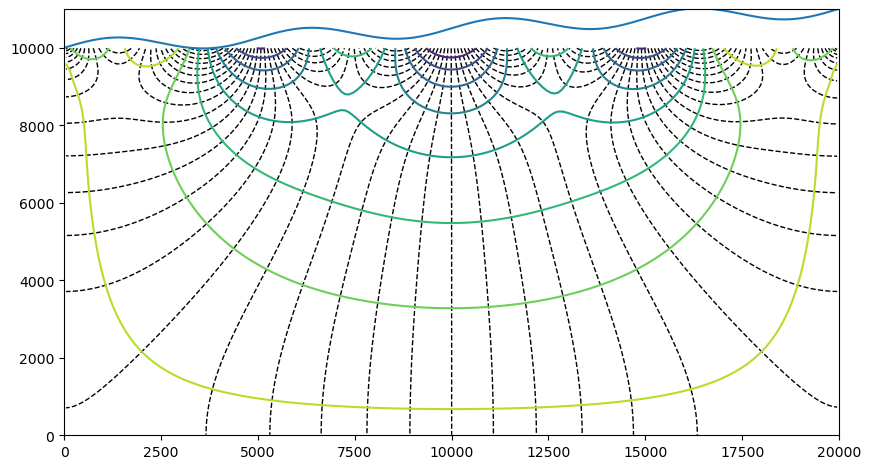

In [ ]:
# create a plot of the model results
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect(1)
pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row":0})
#pxs.plot_grid()
pxs.contour_array(
    head, 
    levels=np.arange(Lz, z.max(), 25), 
    linewidths=1., 
    colors="k",
    linestyles="dashed",
)
pxs.contour_array(phi, levels=np.linspace(phi.min(), phi.max(), 10))
#pxs.plot_vector(qx, qy, qz, normalize=True, color="black")
ax.set_xlim(0, 20000)
ax.set_ylim(0, 11000)
ax.plot(x, z)